In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 80

ng =7

ng_adju = (/ 2 /) 

ng_refs = (/ 2 , 5 /) 

nref =2

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 10 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 540

data w_diffuse
     &     /1.9 , 1.7 , 1.4 , 1.4,
     &     1.4 , 1.55 , 1.6/

data wgt
     &     /0.7 , 0.7 , 0.7 , 0.5,
     &     0.5 , 0.5 , 0.5/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

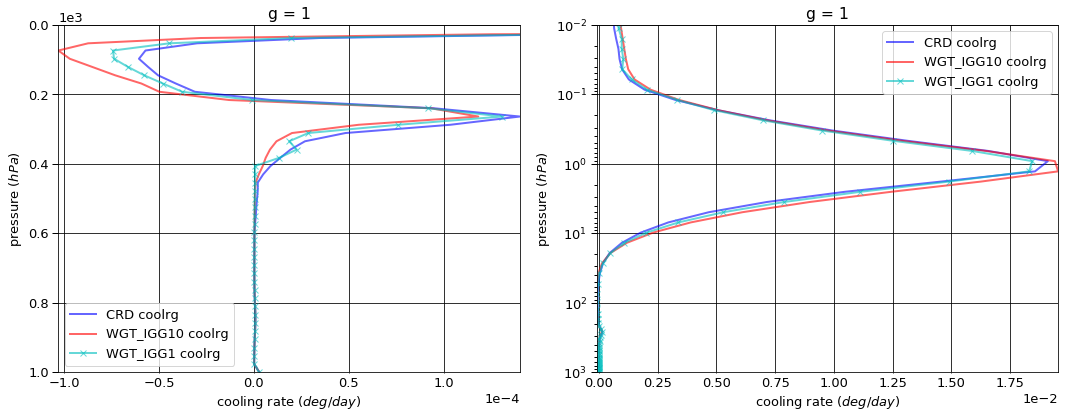

# Figure: cooling rate g-group 2

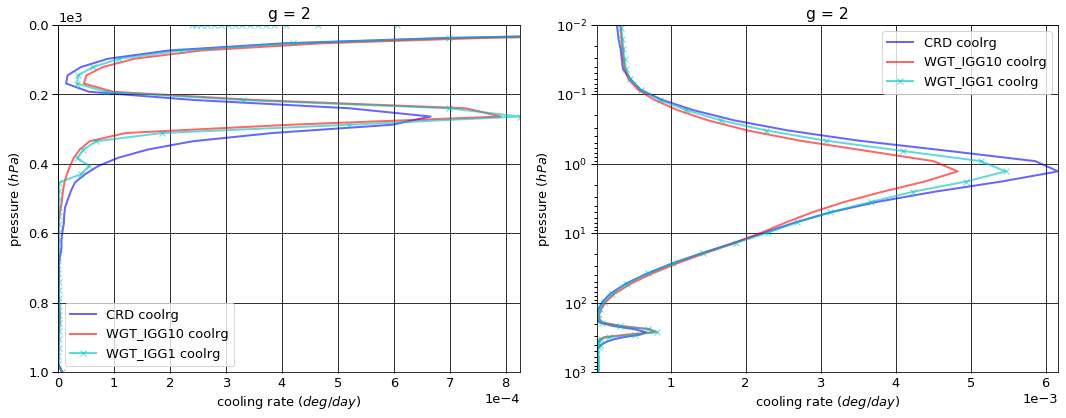

# Figure: cooling rate g-group 3

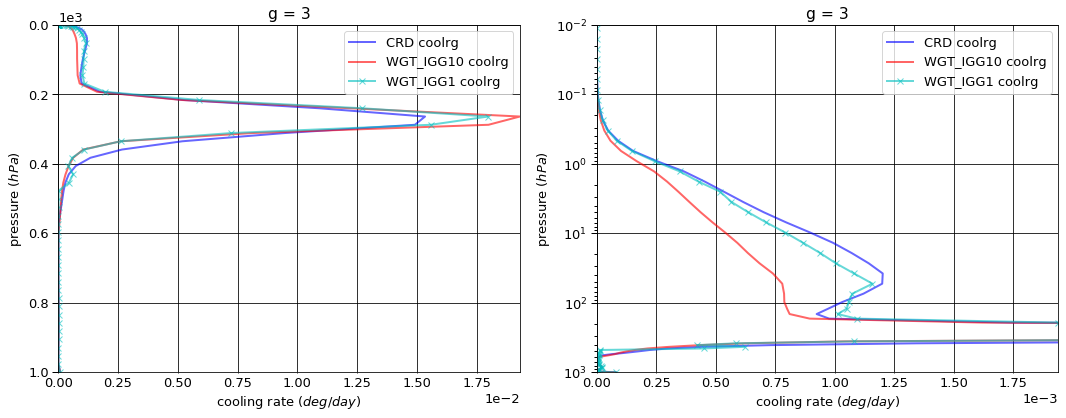

# Figure: cooling rate g-group 4

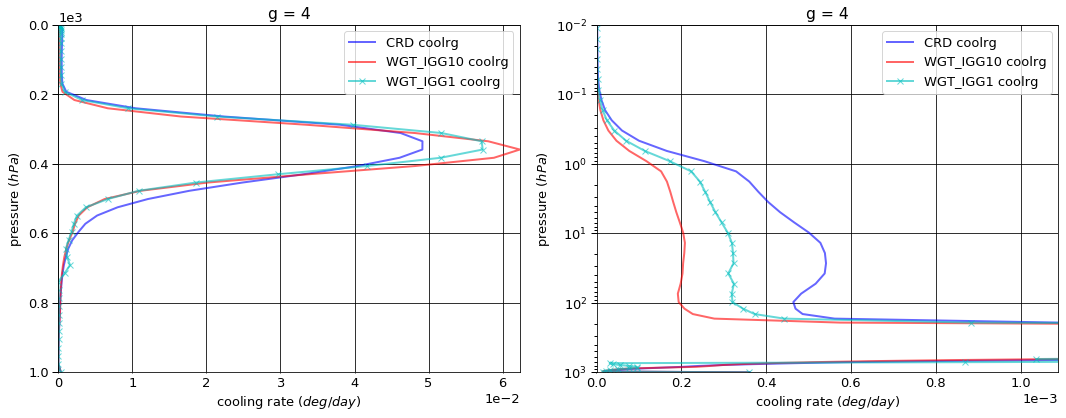

# Figure: cooling rate g-group 5

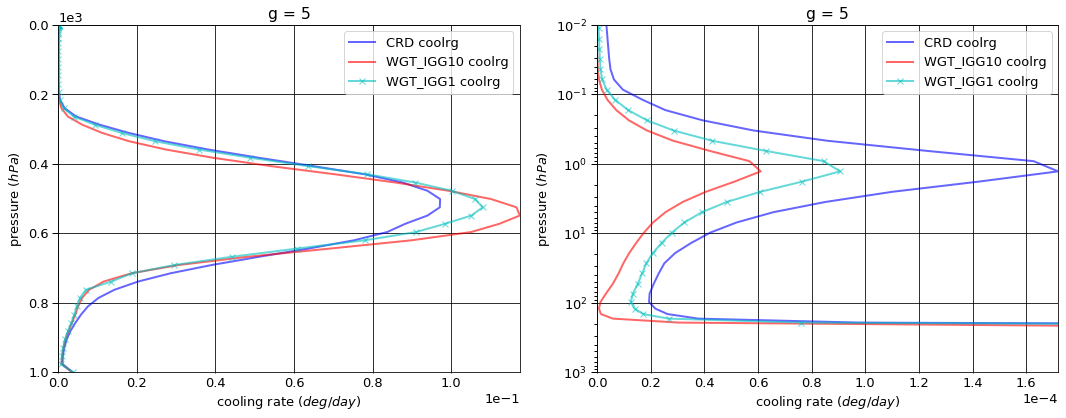

# Figure: cooling rate g-group 6

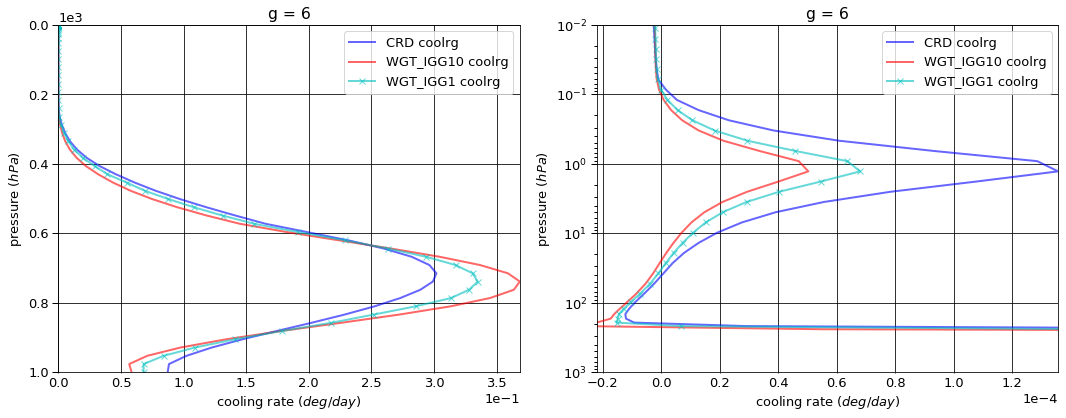

# Figure: cooling rate g-group 7

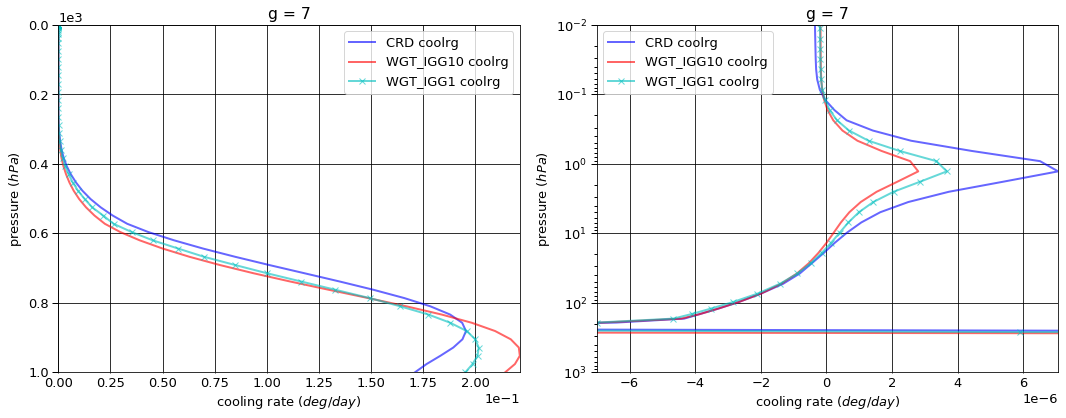

# Figure: cooling rate g-group total

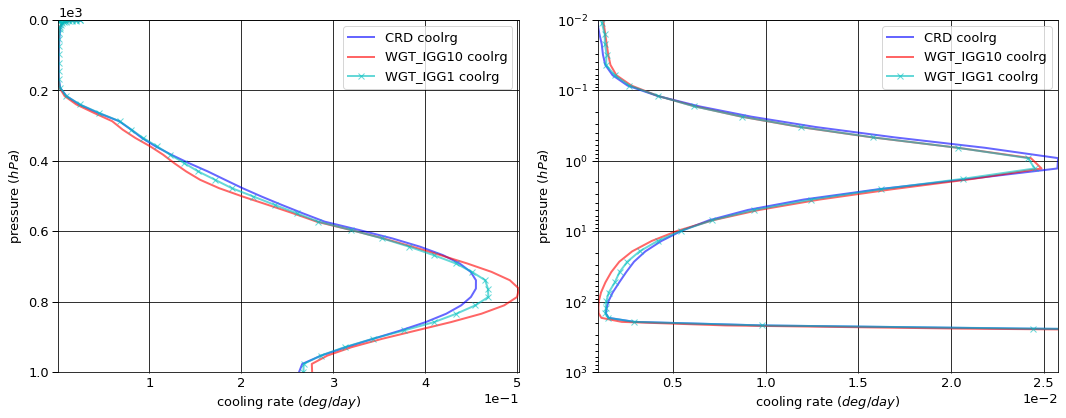

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009686   0.000000  -0.009686
  1013.0   76     -0.017670   0.017662  -0.000008
2 0.0      1      -0.019613   0.000000  -0.019613
  1013.0   76     -0.043948   0.043928  -0.000020
3 0.0      1      -0.216999   0.000000  -0.216999
  1013.0   76     -0.484839   0.484618  -0.000221
4 0.0      1      -1.201004   0.000000  -1.201004
  1013.0   76     -2.193748   2.192749  -0.000999
5 0.0      1      -3.583548   0.000000  -3.583548
  1013.0   76     -5.230554   5.220726  -0.009828
6 0.0      1     -13.626457   0.000000 -13.626457
  1013.0   76    -16.493970  15.914481  -0.579490
7 0.0      1     -10.798849   0.000000 -10.798849
  1013.0   76    -11.770679   8.648866  -3.121813


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009990   0.000000  -0.009990
  1013.0   76     -0.017670   0.017662  -0.000008
2 0.0      1      -0.018624   0.000000  -0.018624
  1013.0   76     -0.043948   0.043928  -0.000020
3 0.0      1      -0.214907   0.000000  -0.214907
  1013.0   76     -0.484839   0.484618  -0.000221
4 0.0      1      -1.200129   0.000000  -1.200129
  1013.0   76     -2.193748   2.192750  -0.000997
5 0.0      1      -3.620330   0.000000  -3.620330
  1013.0   76     -5.230554   5.221605  -0.008949
6 0.0      1     -13.702851   0.000000 -13.702851
  1013.0   76    -16.493970  16.249955  -0.244015
7 0.0      1     -10.950710   0.000000 -10.950710
  1013.0   76    -11.770679   8.366967  -3.403712


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.009732   0.000000  -0.009732
  1013.0   76     -0.017670   0.017662  -0.000008
2 0.0      1      -0.018925   0.000000  -0.018925
  1013.0   76     -0.043948   0.043928  -0.000020
3 0.0      1      -0.212164   0.000000  -0.212164
  1013.0   76     -0.484839   0.484618  -0.000221
4 0.0      1      -1.183125   0.000000  -1.183125
  1013.0   76     -2.193748   2.192750  -0.000997
5 0.0      1      -3.565180   0.000000  -3.565180
  1013.0   76     -5.230554   5.221060  -0.009494
6 0.0      1     -13.627671   0.000000 -13.627671
  1013.0   76    -16.493970  16.182539  -0.311432
7 0.0      1     -10.902630   0.000000 -10.902630
  1013.0   76    -11.770679   8.248786  -3.521893


WGT_IGG10 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -3.039027e-04  0.000000e+00 -3.039027e-04
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1      9.892930e-04  0.000000e+00  9.892930e-04
  1013.0   76    -6.938894e-18  6.938894e-18  3.388132e-21
3 0.0      1      2.091970e-03  0.000000e+00  2.091970e-03
  1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
4 0.0      1      8.749000e-04  0.000000e+00  8.749000e-04
  1013.0   76     0.000000e+00  1.800000e-06  1.874720e-06
5 0.0      1     -3.678250e-02  0.000000e+00 -3.678250e-02
  1013.0   76     0.000000e+00  8.797000e-04  8.796477e-04
6 0.0      1     -7.639400e-02  0.000000e+00 -7.639400e-02
  1013.0   76     0.000000e+00  3.354740e-01  3.354741e-01
7 0.0      1     -1.518610e-01  0.000000e+00 -1.518610e-01
  1013.0   76     0.000000e+00 -2.818988e-01 -2.818989e-01


WGT_IGG1 - CRD


flug          fldg         fnetg
g pressure level                                          
1 0.0      1     -4.595450e-05  0.000000e+00 -4.595450e-05
  1013.0   76     0.000000e+00  0.000000e+00  0.000000e+00
2 0.0      1      6.878970e-04  0.000000e+00  6.878970e-04
  1013.0   76    -6.938894e-18  6.938894e-18  3.388132e-21
3 0.0      1      4.835520e-03  0.000000e+00  4.835520e-03
  1013.0   76     0.000000e+00  0.000000e+00  2.710505e-20
4 0.0      1      1.787910e-02  0.000000e+00  1.787910e-02
  1013.0   76     0.000000e+00  1.800000e-06  1.874720e-06
5 0.0      1      1.836810e-02  0.000000e+00  1.836810e-02
  1013.0   76     0.000000e+00  3.341000e-04  3.341356e-04
6 0.0      1     -1.214000e-03  0.000000e+00 -1.214000e-03
  1013.0   76     0.000000e+00  2.680580e-01  2.680580e-01
7 0.0      1     -1.037810e-01  0.000000e+00 -1.037810e-01
  1013.0   76     0.000000e+00 -4.000800e-01 -4.000800e-01

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.602690e-04
  1001.112500 75     2.900343e-06
2 0.000312    1      1.724206e-04
  1001.112500 75     7.206304e-06
3 0.000312    1      8.208697e-09
  1001.112500 75     7.957134e-05
4 0.000312    1      1.194499e-06
  1001.112500 75     3.619301e-04
5 0.000312    1      1.415137e-06
  1001.112500 75     3.669262e-03
6 0.000312    1     -3.852191e-06
  1001.112500 75     8.730188e-02
7 0.000312    1     -3.926666e-07
  1001.112500 75     1.711767e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      4.409700e-04
  1001.112500 75     2.900343e-06
2 0.000312    1      2.422089e-04
  1001.112500 75     7.206304e-06
3 0.000312    1      5.434439e-09
  1001.112500 75     7.957134e-05
4 0.000312    1      3.762394e-07
  1001.112500 75     3.598531e-04
5 0.000312    1     -8.407928e-07
  1001.112500 75     3.494755e-03
6 0.000312    1     -2.587084e-06
  1001.112500 75     5.851906e-02
7 0.000312    1     -1.948683e-07
  1001.112500 75     2.144787e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      3.249019e-04
  1001.112500 75     2.900343e-06
2 0.000312    1      2.396467e-04
  1001.112500 75     7.206304e-06
3 0.000312    1      8.553556e-09
  1001.112500 75     7.957134e-05
4 0.000312    1      7.527820e-07
  1001.112500 75     3.598531e-04
5 0.000312    1     -4.651418e-07
  1001.112500 75     3.660971e-03
6 0.000312    1     -2.675392e-06
  1001.112500 75     6.801520e-02
7 0.000312    1     -2.155463e-07
  1001.112500 75     1.953762e-01


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.807010e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      6.978829e-05
  1001.112500 75     8.470329e-22
3 0.000312    1     -2.774258e-09
  1001.112500 75     0.000000e+00
4 0.000312    1     -8.182595e-07
  1001.112500 75    -2.077030e-06
5 0.000312    1     -2.255929e-06
  1001.112500 75    -1.745075e-04
6 0.000312    1      1.265107e-06
  1001.112500 75    -2.878283e-02
7 0.000312    1      1.977983e-07
  1001.112500 75     4.330204e-02


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.646329e-04
  1001.112500 75     0.000000e+00
2 0.000312    1      6.722610e-05
  1001.112500 75     8.470329e-22
3 0.000312    1      3.448591e-10
  1001.112500 75     0.000000e+00
4 0.000312    1     -4.417169e-07
  1001.112500 75    -2.077030e-06
5 0.000312    1     -1.880278e-06
  1001.112500 75    -8.291500e-06
6 0.000312    1      1.176799e-06
  1001.112500 75    -1.928669e-02
7 0.000312    1      1.771202e-07
  1001.112500 75     2.419947e-02

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.456156,0.00000,-29.456156
1013.0,76,-36.235408,32.52303,-3.712379



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.717541,0.000000,-29.717541
1013.0,76,-36.235408,32.577486,-3.657922



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-29.519426,0.000000,-29.519426
1013.0,76,-36.235408,32.391344,-3.844065



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.261385,0.000000,-0.261385
1013.0,76,0.000000,0.054457,0.054457



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.06327,0.000000,-0.063270
1013.0,76,0.00000,-0.131686,-0.131686


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000331
1001.112500,75,0.262599



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000680
1001.112500,75,0.276942



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000562
1001.112500,75,0.267502



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000349
1001.112500,75,0.014343



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000231
1001.112500,75,0.004902


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000487,0.000490
2,0.001213,0.001218
3,0.013375,0.013435
4,0.060525,0.060808
5,0.144325,0.145143
6,0.455137,0.456604
7,0.324937,0.322302


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.541951e-19
2,2.122874e-20
3,4.182942e-21
4,5.437189e-22
5,7.067520e-23
6,9.186702e-24
7,1.194132e-24


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.541951e-19,NaN,0.000487,0.000490,0.000487,0.000490,10.0
2,2.122874e-20,0.137674,0.001213,0.001218,0.001700,0.001708,10.0
3,4.182942e-21,0.197041,0.013375,0.013435,0.015075,0.015143,600.0
4,5.437189e-22,0.129985,0.060525,0.060808,0.075600,0.075951,600.0
5,7.067520e-23,0.129985,0.144325,0.145143,0.219925,0.221094,600.0
6,9.186702e-24,0.129985,0.455137,0.456604,0.675063,0.677698,600.0
7,1.194132e-24,0.129985,0.324937,0.322302,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
